# Custom RandomForestRegressor ONNX sklearn model

## Work-in-Progress: Partial working
* Working `sklearn` RF model with a custom `predict()` method
* Working `onnx` RF model that has a partial implementation of the custom `predict()` method


In [1]:

from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
from io import StringIO

from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import update_registered_converter
from skl2onnx.common.data_types import guess_numpy_type
#from skl2onnx.algebra.onnx_ops import # TBD
from skl2onnx.shape_calculators.ensemble_shapes import calculate_tree_regressor_output_shapes
from skl2onnx.operator_converters.random_forest import convert_sklearn_random_forest_regressor_converter


import onnxruntime as rt

from mlprodict.onnxrt import OnnxInference
from pyquickhelper.helpgen.graphviz_helper import plot_graphviz
import matplotlib.pyplot as plt

## Custom Random Forest Model


In [2]:
# define custom RF model class
class CustomRandomForestRegressor(RandomForestRegressor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # override standard predict method
    # modifications:
    #    invoke super class predict() - super_prediction
    #    invoke individual tree estimators
    #    compute mean of collection of tree estimators - tree_mean_prediction
    #    return super_prediction - tree_mean_prediction, this should result in all zero predictions
    def predict(self, X):
        # obtain standard RF prediction
        super_prediction = super().predict(X)

        # compute predictions directly from trees
        tree_predictions = [e.predict(X.to_numpy()) for e in self.estimators_]
        tree_mean_prediction = np.mean(np.array(tree_predictions), axis=0)

        # return the difference between the two predictions, values should all be zero
        return super_prediction - tree_mean_prediction


In [3]:
rf = CustomRandomForestRegressor(
    n_estimators=8,
    random_state=13
)


## Create some test data

In [4]:
test_data = """x1,x2,y
1,2,11
-3,1,-1
0,0,1
1,1,7
"""
test_df = pd.read_csv(StringIO(test_data))
test_df

,x1,x2,y
0,1,2,11
1,-3,1,-1
2,0,0,1
3,1,1,7


## Train model

In [5]:
rf.fit(test_df.drop(['y'], axis=1), test_df['y'])

CustomRandomForestRegressor()

## Demonstrate that predict() method works

**NOTE**:  All predicted values should be zero.

In [6]:
rf_prediction = rf.predict(test_df.drop(['y'], axis=1))
print(f"predictions: {rf_prediction}")
print(f"R2 score: {rf.score(test_df.drop(['y'], axis=1), test_df['y'])}")
print('sklearn model', np.max(np.abs(test_df['y'] - rf_prediction)))

predictions: [0. 0. 0. 0.]
R2 score: -0.8901098901098901
sklearn model 11.0


## Setup to save custom RF model in ONNX

### Helper functions
#### shape calculator helper

In [7]:
# shape calculator
def custom_regressor_shape_calculator(operator):
    # TODO: may get by with standard shape calculator

    # call standard sklearn shape calculator
    calculate_tree_regressor_output_shapes(operator)

#### Custom operator converter helper

In [8]:
# converter helper
def custom_regressor_converter(scope, operator, container):
    # TODO: need to figure out the custom ops to return zero 
   
    # TODO: we may need to provide custom equivalent
    # call standard sklearn converter
    convert_sklearn_random_forest_regressor_converter(scope, operator, container)

### Register Custom model with onnx

In [9]:
# register custom model with onnx
update_registered_converter(
    CustomRandomForestRegressor,
    "CustomRandomForestRegressor",
    custom_regressor_shape_calculator,  # custom built
    custom_regressor_converter,  # custom built
    # required to support standard sklearn RF class
    options={
        'decision_path': [True, False],
        'decision_leaf': [True, False]
    }
)

## Save model in onnx format

In [10]:
# save model as onnx
explanatory_var = [('float_input', FloatTensorType([None, 2]))]
onnx_model = convert_sklearn(rf, initial_types=explanatory_var)

with open('./rf_custom_model.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())

## Display computational graph

In [11]:
current_path = %env PATH
%env PATH=/opt/conda/envs/onnx_training/bin:$current_path

env: PATH=/opt/conda/envs/onnx_training/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


**NOTE**: Missing ops to replicate the custom `predict()` method.

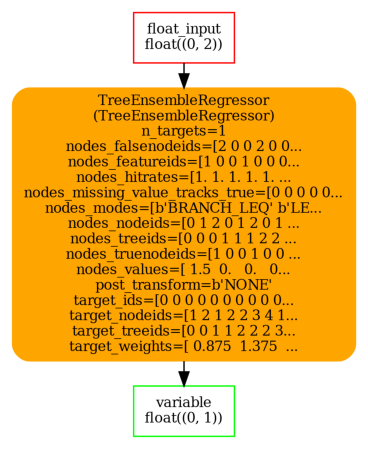

In [12]:
oinf = OnnxInference(onnx_model)
plt.figure(figsize=(10,8))
ax = plot_graphviz(oinf.to_dot())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Load onnx model from disk and score some data

In [13]:
# retrieve model from disk
sess = rt.InferenceSession('./rf_custom_model.onnx')

In [14]:
# get model names
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [15]:
# generate predictions
list_of_predictions = sess.run(
    [label_name], 
    {'float_input': test_df.drop(['y'], axis=1).to_numpy().astype(np.float32)}
)
prediction = list_of_predictions[0]

**NOTE**: Custom operations not currently implemented.  Predictions will not match above.

In [16]:
print(f'prediction shape: {prediction.shape}\n{prediction}')

prediction shape: (4, 1)
[[10.  ]
 [ 1.25]
 [ 3.25]
 [ 6.25]]


In [17]:
print('restored onnx model', np.max(np.abs(test_df['y'] - prediction.reshape(-1,))))

restored onnx model 2.25


## Explore the model metadata, inputs and outputs

In [18]:
model_metadata = sess.get_modelmeta()
print(f'description: {model_metadata.description}')
print(f'domain: {model_metadata.domain}')
print(f'graph_name: {model_metadata.graph_name}')
print(f'producer_name: {model_metadata.producer_name}')
print(f'version: {model_metadata.version}')

description: 
domain: ai.onnx
graph_name: afbd726135c64ca08ebab72acd7aed32
producer_name: skl2onnx
version: 0


In [19]:
print("model inputs:")
for i in sess.get_inputs():
    print(f'name: {i.name}, shape:{i.shape}, dtype:{i.type}')

model inputs:
name: float_input, shape:[None, 2], dtype:tensor(float)


In [20]:
print("model outputs:")
for o in sess.get_outputs():
    print(f'name: {o.name}, shape: {o.shape}, dtype: {o.type}')

model outputs:
name: variable, shape: [None, 1], dtype: tensor(float)
